# 1. Overview of Chatbot Personality Analysis

This notebook provides an overview of this research product by describing the research questions, the data gathered, and the analysis conducted. Each research question is addressed in a separate notebook as follow:
  
<code>
1_RQ1_user_experience.ipynb 
2_RQ2_personality_simulation.ipynb 
3_RQ3_user_personality.ipynb 
</code>


# 2. Research Questions

#### RQ1: Does the personality demonstrated by a chatbot affect the user’s experience?

- Which chatbot did the participant prefer? (show counts for each chatbot - bar chart, pie chart, ratio etc.)
    - How does this align with the participant's personality? (correlation between extraversion and preference, agreebleness and preference, can use logistic regression or point biserial correlation)
- Is the preferred chatbot experience positively correlated with conversation engagement metrics such as conversation length? (logistic regression)


#### RQ2: Can Personality be simulated by a chatbot?

- Do participants reliably identify differences between chatbot personality?
- Do participants prefer one chatbot over the other because of its personality?

#### RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

- Do self-described personality traits (beliefs) correlate with interaction metrics (behaviour)?
- Can we use NLP on participant utterances to extract personality traits?
    - How do extracted personality traits correlate with self-described personality traits?


# 3. Data Gathered

Data for this analysis was gathered via an online user study in which participants interacted with two chatbots designed with disctinct personalities. The personalities differ across two factors of the Big 5 Personality Trait model (https://en.wikipedia.org/wiki/Big_Five_personality_traits). These factors are Extroversion (outgoing/energetic vs. solitary/reserved) and Agreeableness (friendly/compassionate vs. challenging/detached). Participants filled out a demographic and personality survey before interacting with the chatbots. After each interaction the participants filled out a survey about how they perceived the chatbot they just used. At the end of the experiment participants filled out a final survey describing which chatbot they preferred. 

# 4. Analysis

We analysis survey responses (text) as well as conversation logs (json). We extract features from the json data including number of conversation turns, average length of user utterances etc. 

### Read in dialog files (JSON)


Each user utterance in a conversation is stored in a separate JSON file which contains fields about the message, the user, and the conversation:

Message:
- type
- ID
- timestamp
- Text

User:
- ID
- Name

Conversation:
- ID

Bot:
- ID
- Name


In [1]:
import json
from pandas.io.json import json_normalize
import os
import logging
import logging.handlers
import pandas as pd
import numpy as np
import glob
from datetime import datetime,timedelta
from collections import Counter
import nltk 
from functools import reduce
import re
import itertools
from scipy.stats import pointbiserialr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Unpickle Anonymised Data

### Demographic Dataframe
This data was collected from the Pre-Interaction survey taken by the participants.
The data has been anonymised, and stored in a dataframe with the following columns:

- Timestamp (The time they began taking the survey)
- Age 
- Gender
- Do you know what a chatbot is? 
- If Yes, describe your understanding of what a chatbot is
- How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?
- Their answers to a range of personality questions 



In [2]:
#unpickle df_dem
df_dem = pd.read_pickle("./df_dem.pkl")

### Interaction DataFrames

This code parses the json files from the chatbot interactions and stores the data in a dataframe with the following columns:

- Duration (Lenght of conversation in minutes)
- Chatbot (Name of chatbot)
- NumberOfTurns (absolute count of conversation turns made by the participant)
- Utterance (A list of all the participant's utterances)
- Word Count (Total word count of all the participant's utterances (sum))
- Average Utterance Length (The average character length of the participant's utteranes (mean))




In [3]:
#unpickle df_chatbotdata
df_chatbotdata = pd.read_pickle("./df_chatbotdata.pkl")
# convert duratin to minutes from ns
df_chatbotdata = df_chatbotdata.astype({'Duration': 'timedelta64[m]'})

### Complete Data

This data comprises of all four surveys taken by the particpants and the data collected from their interactions with the chatbots

In [4]:
#unpickle df_merged
df_merged = pd.read_pickle("./df_merged.pkl")
df_merged = df_merged.astype({'Duration_x': 'timedelta64[m]'})
df_merged = df_merged.astype({'Duration_y': 'timedelta64[m]'})

# Demographic Visualisations

### Bar Chart to depict the Age Distribution of the participants

In [5]:
# Age
fig = px.histogram(df_dem, x="Age")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Age Distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Bar Chart to depict the Gender Distribution of the participants

In [6]:
fig = px.histogram(df_dem, x="Gender")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Gender distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Bar Chart to depict how often the partipants use a chatbot

In [7]:
fig = px.histogram(df_dem, x='How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Frequency distribution of chatbot usage",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
       xaxis_title = "Frequency of chatbot use",
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Pie Chart to depict if the particpants knew what a chatbot was

In [8]:
labels = df_dem['Do you know what a chatbot is?'].value_counts().index
values = df_dem['Do you know what a chatbot is?'].value_counts().values

fig = px.pie(labels=labels, values=values, names=labels)
fig.update_layout(
    width=600,
    height=650,
    title={
        'text': "Do you know what a chatbot is?",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [9]:
df_merged['If Yes, describe your understanding of what a chatbot is ']

0     software used to 'chat' with a user in-place o...
1     A computer program that can talk to me in a ch...
2     A chatbot is an account where a client (user) ...
3                                       Chat with an AI
4                                                   NaN
5     A application or AI that responds to questions...
6     a software application used to create a chat c...
7     A program that takes questions  in the form of...
8     a program that replies usually through text to...
9     Software the you can have a conversation simil...
10     Interactive AI designed for online conversations
11    A piece of software that allows the user to ha...
12    a computing machine that you can converse with...
13    Automated tool which will have conversation wi...
14    a messaging service where you're interacting w...
15    An online system that you can converse with, i...
16    It is a chatroom with an automated response th...
Name: If Yes, describe your understanding of wha

## Personality Assignment

Automation of the Big Five Inventory Scoring Key: (https://fetzer.org/sites/default/files/images/stories/pdf/selfmeasures/Personality-BigFiveInventory.pdf)

In [10]:
df_dem["extraversion_score"] = ""
df_merged["extraversion_score"] = ""
df_dem["agreeableness_score"] = ""
df_merged["agreeableness_score"] = ""

for index, row in df_dem.iterrows():
    df_dem["extraversion_score"][index] = np.mean((6 - df_dem['I am reserved'][index] , df_dem['I am full of energy'][index], df_dem['I generate a lot of enthusiasm '][index] ,6 - df_dem['I tend to be quiet '][index], df_dem['I have an assertive personality'][index] , 6 - df_dem['I am sometimes shy, inhibited'][index], df_dem['I am outgoing, sociable '][index]))
    df_dem["agreeableness_score"][index] = np.mean((6 - df_dem['I tend to find fault with others'][index], df_dem['I am helpful and unselfish with others'][index], 6 - df_dem['I start quarrels with others'][index] , df_dem['I have a forgiving nature'][index] ,df_dem['I am generally trusting'][index] , 6 - df_dem['I can be cold and aloof '][index], df_dem['I am considerate and kind to almost everyone'][index],  6 - df_dem['I am sometimes rude to others'][index], df_dem['I like to cooperate with others'][index]))

df_merged["extraversion_score"] = df_dem["extraversion_score"]
df_merged["agreeableness_score"] = df_dem["agreeableness_score"]


/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Personality of Particpants (Extraversion)

In [11]:
counts, bins = np.histogram(df_dem['extraversion_score'], bins=range(0, 7))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Extraversion Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()


In [12]:
# mean 
np.mean(df_dem['extraversion_score'])

3.058823529411765

### Personality of Particpants (Agreeableness)

In [13]:
# Personality of Participants 
counts, bins = np.histogram(df_dem['agreeableness_score'], bins=range(0, 7))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Agreeableness Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=22,
        color="#000000"
    ),
)
fig.show()

In [14]:
np.mean(df_dem['agreeableness_score'])

3.973856209150327

## Box Plot  Interaction Duration

In [15]:
fig = px.box(df_chatbotdata , "Chatbot", "Duration", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Duration of Interaction in Minutes",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Duration (Minutes)",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)

fig.show()


In [16]:
# Variance 
print("Nasoto Variance: " + str(df_merged.loc[:,"Duration_x"].var()))
print("Makoto Variance: " + str(df_merged.loc[:,"Duration_y"].var()))

Nasoto Variance: 18.36764705882353
Makoto Variance: 3.2794117647058822


## BoxPlot Number of Conversation Turns

In [17]:
fig = px.box(df_chatbotdata  , "Chatbot", "NumberOfTurns", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Number of Conversation Turns",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Turns",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Word Count

In [18]:
fig = px.box(df_chatbotdata  , "Chatbot", "Word_Count", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Total User Word Count",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Words",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Average Utterance Length

In [19]:
fig = px.box(df_chatbotdata  , "Chatbot", "Avg_Utt_Len", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Average Utterance Length (characters)",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Number of Characters",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Preferred Chatbot

In [20]:
labels = df_merged['Which chatbot did you prefer interacting with?'].value_counts().index
values = df_merged['Which chatbot did you prefer interacting with?'].value_counts().values

fig = px.pie(labels=labels, values=values, names=labels, color_discrete_sequence=["green", "orange"])
fig.update_layout(
    width=600,
    height=650,
    title={
        'text': "Preferred Chatbot by Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Is the preferred chatbot experience positively correlated with conversation engagement metrics ?

These Metrics include:
- Duration (minutes)
- Conversation length(number of turns)
- Word Count 
- Average Utterance length

### Duration (minutes)

In [21]:
knowledgeRateNasoto = df_merged['Duration_y']
knowledgeRateMakoto = df_merged['Duration_x'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)


PointbiserialrResult(correlation=0.15561248869152916, pvalue=0.5509164374540585)
PointbiserialrResult(correlation=0.06940595855544199, pvalue=0.7912487410873233)


### Conversation length(number of turns)

In [22]:

knowledgeRateNasoto = df_merged['NumberOfTurns_x']
knowledgeRateMakoto = df_merged['NumberOfTurns_y'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=-0.20554047538140596, pvalue=0.4286993015297625)
PointbiserialrResult(correlation=0.195363742871168, pvalue=0.4523900092475758)


### Word Count

In [23]:
knowledgeRateNasoto = df_merged['Word_Count_x']
knowledgeRateMakoto = df_merged['Word_Count_y'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)




PointbiserialrResult(correlation=-0.1587189008812192, pvalue=0.5428921664494841)
PointbiserialrResult(correlation=-0.06239932586418605, pvalue=0.8119484399379424)


### Average Utterance Length

In [24]:
knowledgeRateNasoto = df_merged['Avg_Utt_Len_x']
knowledgeRateMakoto = df_merged['Avg_Utt_Len_y'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=-0.1033710414508296, pvalue=0.6929861170959422)
PointbiserialrResult(correlation=-0.12795529369832204, pvalue=0.6245528230730844)


# Is the preferred chatbot correlated with the rating scored by the particpants

These Ratings include: 
- Knowledge
- Attitude/Personality
- Quality of Conversation

### Dataframe containg the ratings for each chatbot 

In [25]:

df_nas = pd.DataFrame(columns = ['Chatbot', 'Knowledge', 'QualityOfConvo', "Attitude"]) 
df_nas['Chatbot'] = df_merged['Chatbot_x']
df_nas['Knowledge'] = df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?']
df_nas['QualityOfConvo'] = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"]
df_nas['Attitude'] = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"]

In [26]:
df_rates = pd.DataFrame(columns = ['Chatbot', 'Knowledge', 'QualityOfConvo', "Attitude"]) 
df_rates['Chatbot'] = df_merged['Chatbot_y']
df_rates['Knowledge'] = df_merged['How would you rate your experience with Makoto based on its knowledge?']
df_rates['QualityOfConvo'] = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"]
df_rates['Attitude'] = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"]
df_rates = df_nas.append(df_rates)

## Knowledge

In [27]:
fig = px.box(df_rates , "Chatbot", "Knowledge", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on Chatbot's Knowledge",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Rating",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
    
)

fig.show()

In [28]:
# mean 
print("Nasoto: " + str(np.mean(df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?'])))
print("Makoto: " + str(np.mean(df_merged['How would you rate your experience with Makoto based on its knowledge?'])))

Nasoto: 3.6470588235294117
Makoto: 3.588235294117647


In [29]:
# variance 
print("Nasoto: " + str(np.var(df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?'])))
print("Makoto: " + str(np.var(df_merged['How would you rate your experience with Makoto based on its knowledge?'])))

Nasoto: 1.0519031141868513
Makoto: 1.5363321799307956


In [30]:
# rating for Knowledge
knowledgeRateNasoto = df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?']
knowledgeRateMakoto = df_merged['How would you rate your experience with Makoto based on its knowledge?'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print('Nasoto: ' + str(pbc_RateNasoto))
print('Makoto: ' + str(pbc_RateMakoto))



Nasoto: PointbiserialrResult(correlation=0.34800496568346667, pvalue=0.17105812247202284)
Makoto: PointbiserialrResult(correlation=-0.5146502354656655, pvalue=0.03453057958723658)


## Attitude/Personality

In [31]:
fig = px.box(df_rates , "Chatbot", "Attitude", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on Chatbot's Attitude/Personality",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Ratings",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()


In [32]:
# variance 
print("Nasoto: " + str(np.var(df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"])))
print("Makoto: " + str(np.var(df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"]  )))

Nasoto: 1.7093425605536332
Makoto: 0.9480968858131488


In [33]:
# rating for Personality 
personalityRateNasoto = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"]
personalityRateMakoto = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, personalityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, personalityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.3775498108185499, pvalue=0.13516206739920897)
PointbiserialrResult(correlation=-0.5381436055050598, pvalue=0.02585480550580951)


## Quality of Conversation

In [34]:

fig = px.box(df_rates , "Chatbot", "QualityOfConvo", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on the Quality of the Conversation",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Ratings",
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [35]:
# variance 
print("Nasoto: " + str(np.var(df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"])))
print("Makoto: " + str(np.var(df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"] )))

Nasoto: 1.42560553633218
Makoto: 1.2664359861591694


In [36]:
# mean
print("Nasoto: " + str(np.mean(df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"])))
print("Makoto: " + str(np.mean(df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"] )))

Nasoto: 3.4705882352941178
Makoto: 3.7058823529411766


In [37]:
#Rating Quality of Conversation 
qualityRateNasoto = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"]
qualityRateMakoto = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, qualityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, qualityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.5024615781733496, pvalue=0.03982810822116958)
PointbiserialrResult(correlation=-0.2901698516474449, pvalue=0.2585628946532981)


# User Personality Test 

In [38]:
df_personality = pd.DataFrame()

### using df_merged
df_personality['extraversion_score'] = df_merged['extraversion_score']
df_personality['agreeableness_score']= df_merged['agreeableness_score']
df_personality['preffered_Chatbot'] = df_merged['Which chatbot did you prefer interacting with?']



In [39]:
#Convert chatbot names to values for statistical analysis
#0 - Makoto 
#1 - Nasoto
df_personality['Chatbot_binary'] = pd.np.where(df_personality.preffered_Chatbot.str.contains("Makoto"), 0, 1)
df_personality



/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



extraversion_score agreeableness_score preffered_Chatbot  Chatbot_binary
0             2.71429                   4            Nasoto               1
1                   2                   4            Makoto               0
2                   3             4.22222            Makoto               0
3             3.71429             3.88889            Makoto               0
4                   3                   4            Nasoto               1
5             3.42857                   4            Makoto               0
6             2.71429             3.33333            Makoto               0
7             3.57143             4.22222            Makoto               0
8             2.57143                   3            Nasoto               1
9             3.57143             3.44444            Makoto               0
10            3.14286                   4            Makoto               0
11            1.85714             3.88889            Makoto               0
12            4.14286             4.88889            Makoto               0
13            2.85714             4.55556            Makoto               0
14            2.85714             4.22222            Nasoto               1
15            4.14286             3.66667            Nasoto               1
16            2.71429             4.22222            Makoto               0

# Point Biserial Correlation of Persoanlity Scores

In [40]:
chatbot = df_personality['Chatbot_binary']
extraversion_score = df_personality['extraversion_score']
agreeableness_score = df_personality['agreeableness_score']

#pbc of extraversion scores
pbc_extraversion = pointbiserialr(chatbot, extraversion_score)
pbc_agreeableness = pointbiserialr(chatbot, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)


PointbiserialrResult(correlation=-0.0017285626305627334, pvalue=0.9947466650585)
PointbiserialrResult(correlation=-0.2929374625741902, pvalue=0.2538413503593661)


# Preferrences Plot

In [41]:
# scatter plot extraversion v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['extraversion_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Extraversion Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [42]:
# scatter plot agreeableness v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['agreeableness_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Agreeableness Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

#### Get total word count for each chatbot 

In [43]:
total_wc_makoto = df_merged['Word_Count_y'].sum(axis = 0, skipna = True) 
total_wc_nasoto = df_merged['Word_Count_x'].sum(axis = 0, skipna = True)

#### Average word Count 

In [44]:
avgWCMakoto = total_wc_makoto/ len(df_merged.index)
avgWCNasoto = total_wc_nasoto / len(df_merged.index)

In [45]:
total_cc_makoto = df_merged['Avg_Utt_Len_y'].sum(axis = 0, skipna = True) 
total_cc_nasoto = df_merged['Avg_Utt_Len_x'].sum(axis = 0, skipna = True)

avgCCMakoto = total_cc_makoto / len(df_merged.index)
avgCCNasoto = total_cc_nasoto / len(df_merged.index)


In [46]:
df_length =  pd.DataFrame()

df_length['preffered_chatbot'] =  df_merged['Which chatbot did you prefer interacting with?']
df_length['numberofTurnsMakoto'] = df_merged['NumberOfTurns_y']
df_length['numberofTurnsNasoto'] = df_merged['NumberOfTurns_x']
df_length['AvgUttLenMakoto'] = df_merged['Avg_Utt_Len_y']
df_length['AvgUttLenNasoto'] = df_merged['Avg_Utt_Len_x']


In [47]:
# data frame for utterance data 
utterance_data =[['Makoto', sum(df_length['numberofTurnsMakoto']),total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto],
             ['Nasoto', sum(df_length['numberofTurnsNasoto']),total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto ]] 

df_utterance = pd.DataFrame(utterance_data, columns = ['Chatbot', 'NumberOfTurns', 'TotalWordCount', 'AverageNumberWords', 'TotalCharCount' ,'AverageCharCount' ] )
df_utterance
turnsMakoto = sum(df_length['numberofTurnsMakoto'])
turnsNasoto = sum(df_length['numberofTurnsNasoto'])

#### Plot Word Count 

In [48]:
bins=['numberOfTurns','wordCount ', ' avgWordCount ', ' charCount ', ' avgCharCount ']
colors = ['lightslategray',] * 2
colors[1] = 'crimson'

fig = go.Figure(data=[
    go.Bar(name='Nasoto', x=bins, y=[turnsNasoto, total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto], marker_color='orange'),
    go.Bar(name='Makoto', x=bins, y=[turnsMakoto, total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto], marker_color='green'),])
# Change the bar mode
fig.update_layout(
    barmode='group',
    width=700,
    height=750,
    title={
        'text': "Conversation Log Analysis",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Adjectives used to describe Nasoto and Makoto

In [49]:
#Using natural languge processing find the adjectives asscoiated with each chatbot
def find_adjective(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword.lower())
        tagged = nltk.pos_tag(tokens)
        adjective = [w for w,t in tagged if ("JJ") in t]
        if len(adjective) < 1:
            return ''
        else:
            return adjective[0]



In [50]:
df_descriptions = []
# Makoto manually add adjectives
df_descriptions = df_merged['Expand on your answer (optional)_x']
'Expand on your answer (optional).1_x'
'Expand on your answer (optional).2_x',
'Did you enjoy your interaction with Makoto?'
'Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'
'Which chatbot did you prefer interacting with?'
'Explain why you preferred interacting with this chatbot?'

# Nasoto manually add adjectives
'Expand on your answer (optional)_y'
'Expand on your answer (optional).1_y'
'Expand on your answer (optional).2_y'
'Did you enjoy your interaction with Nasoto?'
'Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'
'Which chatbot did you prefer interacting with?'
'Explain why you preferred interacting with this chatbot?'

'Explain why you preferred interacting with this chatbot?'

#### Adjectives associated with Makoto

In [51]:
makoto_adj =  []

makoto_adj = df_merged['Describe Makoto'].apply(find_adjective)
makoto_adj = makoto_adj.append(df_merged['Expand on your answer (optional).2_x'].apply(find_adjective))
#For preferred chatbot = Makoto
# manually add adjectives used to describe makoto 

lst = ['eager', 'less aggressive', 'relaxed', 'genuine', 'engaging', 'cheery', 'fun', 'encouraging', 'happier', 'brighter', 'excited']
 
# # Calling DataFrame constructor on list
df = pd.DataFrame()
df['list'] = lst 
makoto_adj = makoto_adj.append(df['list'])

# clean list 


makoto_adj = list(makoto_adj)
makoto_adj.remove('ucd')


#### Adjectives associted with Nasoto

In [52]:
nasoto_adj =  []
nasoto_adj = (df_merged['Describe Nasoto'].apply(find_adjective))
nasoto_adj = nasoto_adj.append(df_merged['Expand on your answer (optional).2_y'].apply(find_adjective))
lst_nas = ['intutive', 'impolite', 'natural', 'knowledgeable', 'more human', 'unnatural', 'negative', 'passive', 'dull' ]
 
# Calling DataFrame constructor on list
df_nas = pd.DataFrame()
df_nas['list'] = lst_nas
nasoto_adj = nasoto_adj.append(df_nas['list'])
nasoto_adj = list(nasoto_adj)
nasoto_adj.remove('ucd')
nasoto_adj.remove('i')
nasoto_adj.remove('other')

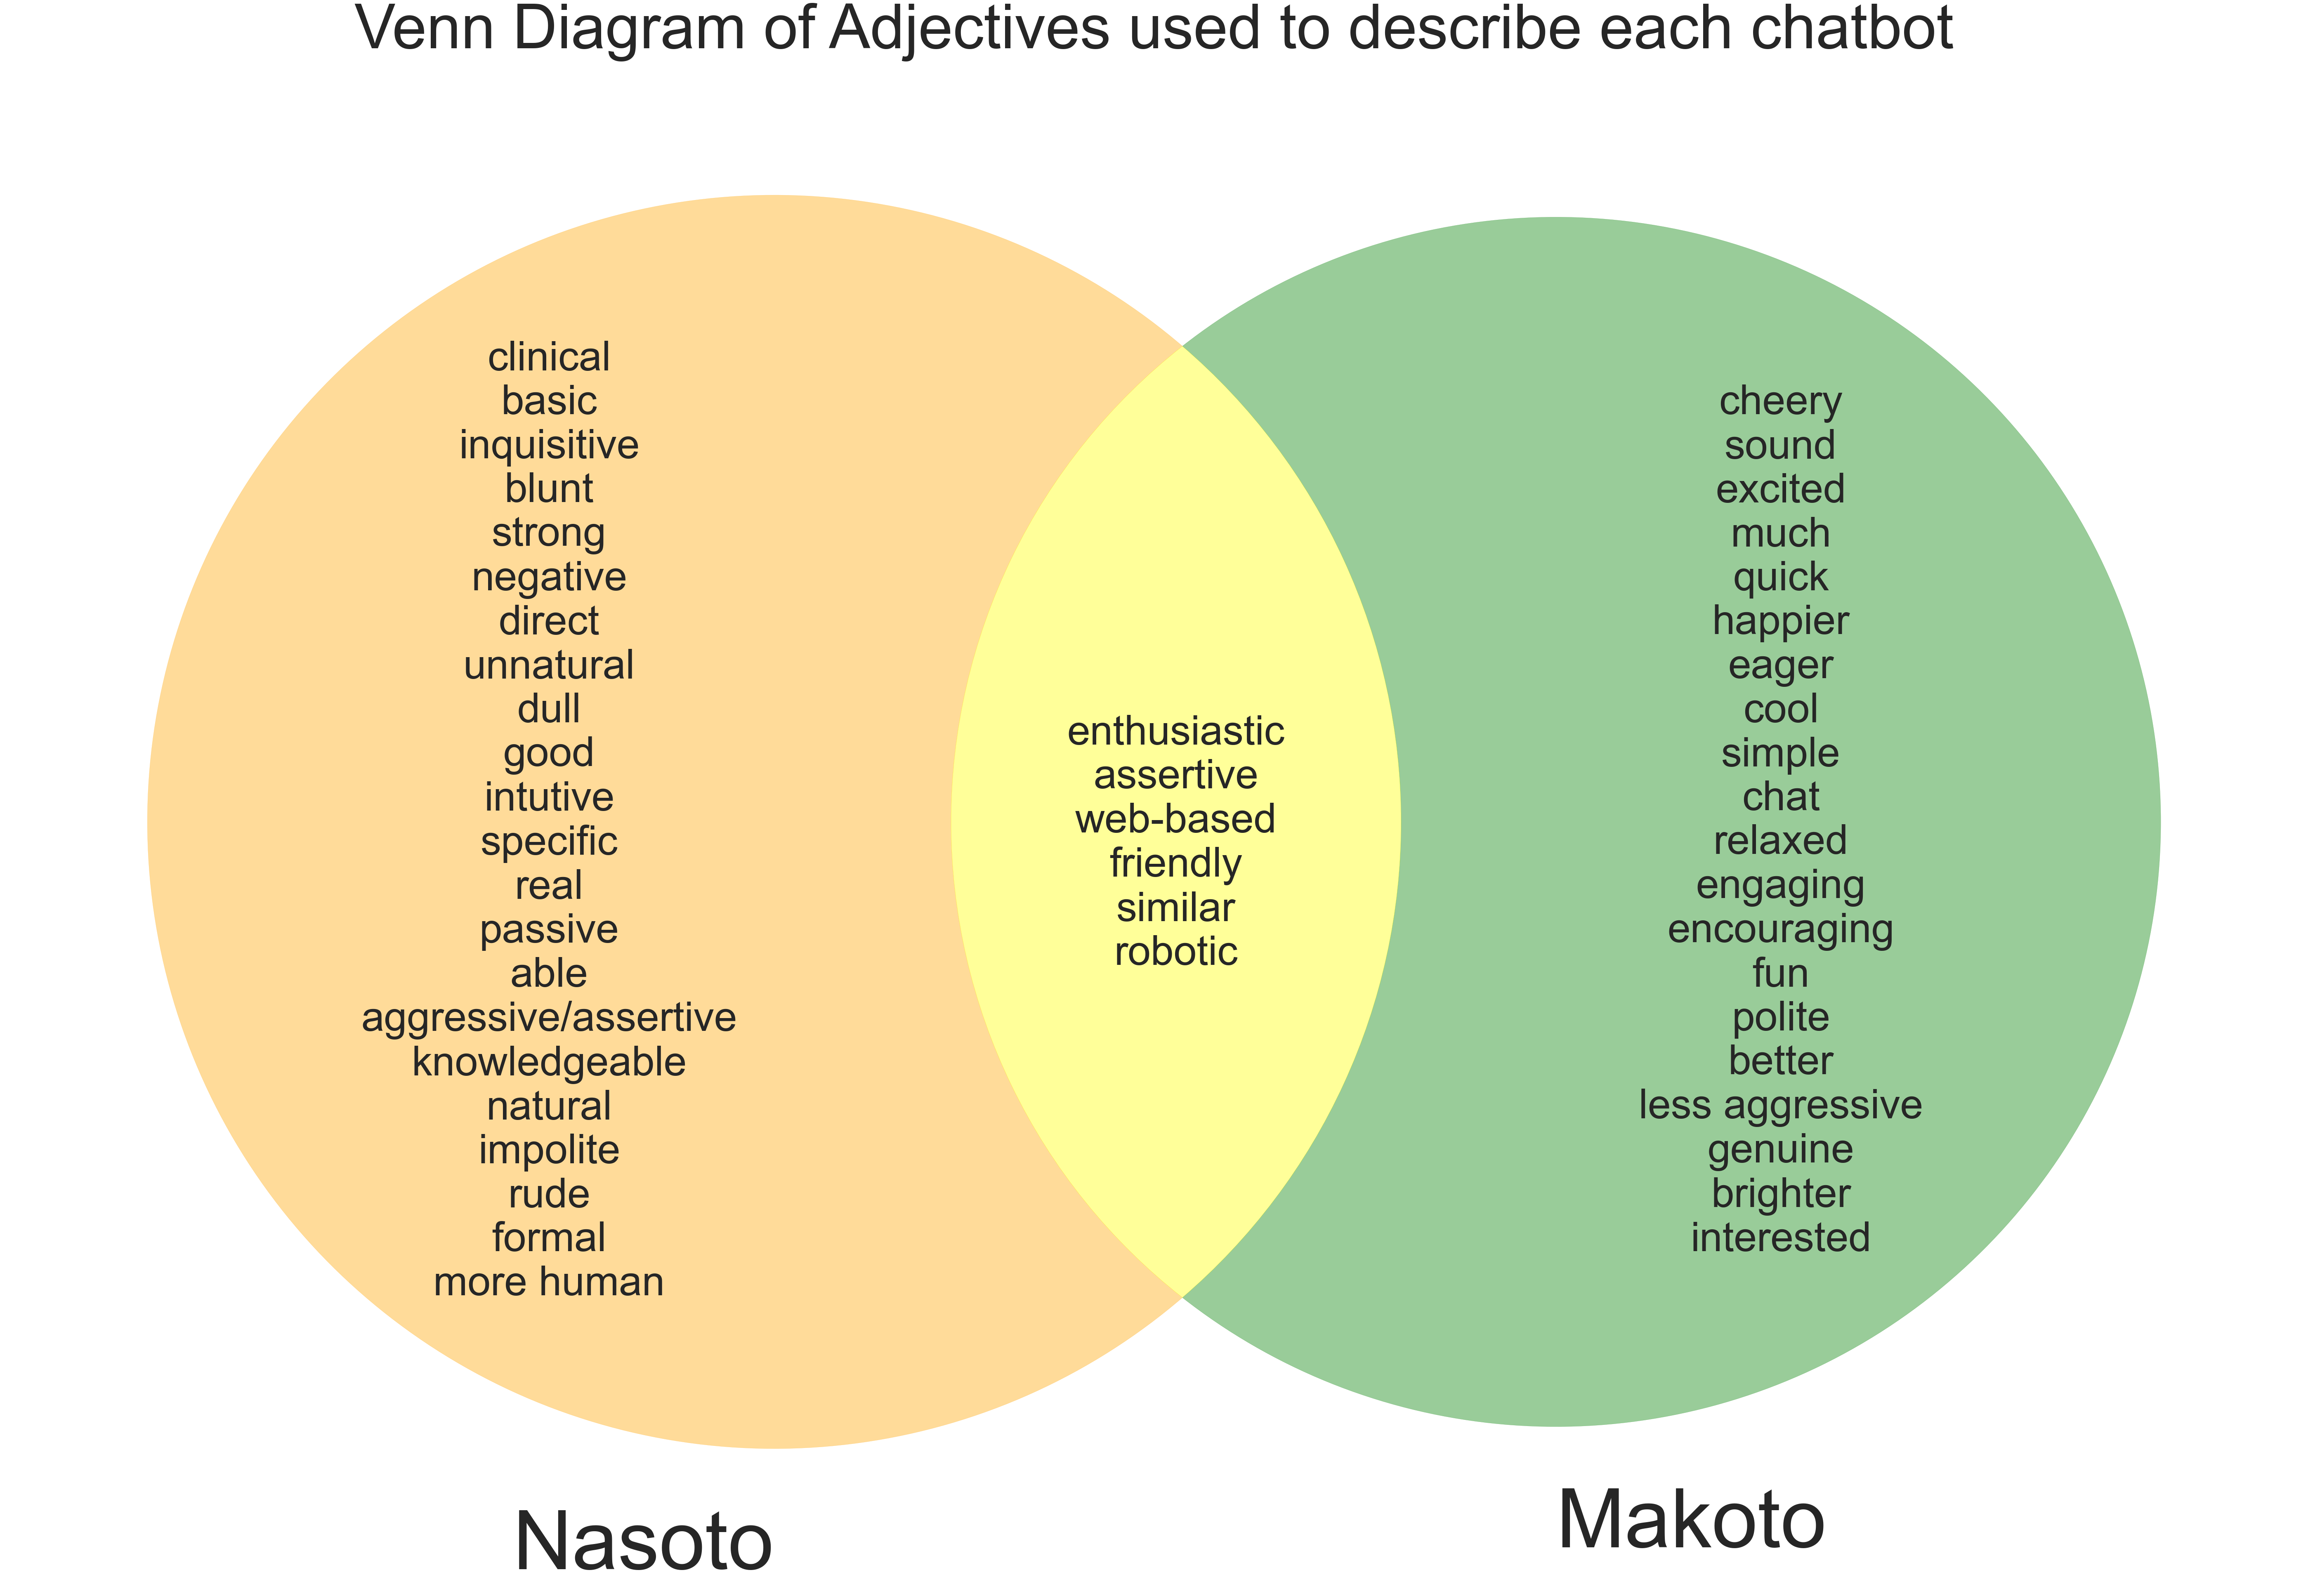

In [53]:
import math, itertools
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
plt.figure(figsize=(100, 110))
plt.title('Venn Diagram of Adjectives used to describe each chatbot').set_fontsize(150)
makotoSet = set(makoto_adj)
nasotoSet = set(nasoto_adj)

s = [nasotoSet, makotoSet]

def gen_index(n):
    x = -1
    while True:       
        while True:
            x = x + 1
            if bin(x).count('1') == n:
                break
        yield x
def make_intersections(sets):
    l = [None] * 2**len(sets)
    for i in range(1, len(sets) + 1):
        ind = gen_index(i)
        for subset in itertools.combinations(sets, i):
            inter = set.intersection(*subset)
            l[next(ind)] = inter
    return l
def bits2indices(b):
    l = []
    if b == 0:
        return l
    for i in reversed(range(0, int(math.log(b, 2)) + 1)):
        if b & (1 << i):
            l.append(i)
    return l
def number2venn_id(x, n_fill):
    id = bin(x)[2:].zfill(n_fill)
    id = id[::-1]
    return id

def sets2dict(s):
    l = make_intersections(s)
    d = {}
    for i in range(1, len(l)):
        d[number2venn_id(i, len(s))] = l[i]
        for j in range(1, len(l)):
            if bin(j).count('1') < bin(i).count('1'):
                l[j] = l[j] - l[i]
                d[number2venn_id(j, len(s))] = l[j] - l[i]
    return d
# Create dictionary from sets
d = sets2dict(s)

h = venn2(s, ('Nasoto', 'Makoto'))
for text in h.set_labels:
    text.set_fontsize(200)
h.get_patch_by_id('01').set_color('green')
h.get_patch_by_id('10').set_color('orange')
h.get_patch_by_id('11').set_color('yellow')
for k, v in d.items():
    l = h.get_label_by_id(k)
    if l:
        l.set_text('\n'.join(map(str, v)))
        l.set_fontsize(100)

plt.show()

### Demographic Perception of the Chatbots

In [54]:
def find_PRP(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword.lower())
        tagged = nltk.pos_tag(tokens)
        pronoun = [w for w,t in tagged if ("PRP") in t]
        if len(pronoun) < 1:
            return ''
        else:
            return pronoun[0]

In [55]:
# Look at the use of personal pronouns 
df_descriptions = []
# Makoto manually add adjectives
df_descriptions_Makoto = []
df_descriptions_Makoto = (df_merged['Expand on your answer (optional)_x'].apply(find_PRP))
df_descriptions_Makoto = df_descriptions_Makoto.append(df_merged['Describe Makoto'].apply(find_PRP))
df_descriptions_Makoto = df_descriptions_Makoto.append(df_merged['Expand on your answer (optional).1_x'].apply(find_PRP))
df_descriptions_Makoto = df_descriptions_Makoto.append(df_merged['Expand on your answer (optional).2_x'].apply(find_PRP))
df_descriptions = df_descriptions_Makoto.append(df_merged['Did you enjoy your interaction with Makoto?'].apply(find_PRP))

# Nasoto manually add adjectives
df_descriptions_Nasoto = []
df_descriptions_Nasoto = (df_merged['Expand on your answer (optional)_y'].apply(find_PRP))
df_descriptions_Nasoto = df_descriptions_Nasoto.append(df_merged['Describe Nasoto'].apply(find_PRP))
df_descriptions_Nasoto = df_descriptions_Nasoto.append(df_merged['Expand on your answer (optional).1_y'].apply(find_PRP))
df_descriptions_Nasoto = df_descriptions_Nasoto.append(df_merged['Expand on your answer (optional).2_y'].apply(find_PRP))
df_descriptions_Nasoto = df_descriptions_Nasoto.append(df_merged['Did you enjoy your interaction with Nasoto?'].apply(find_PRP))

df_descriptions = (df_merged['Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Which chatbot did you prefer interacting with?'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Explain why you preferred interacting with this chatbot?'].apply(find_PRP))

In [56]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [57]:
wordListToFreqDict(list(df_descriptions_Makoto))

{'it': 12,
 'they': 3,
 '': 42,
 'its': 2,
 'you': 2,
 'my': 2,
 'he': 3,
 'their': 1,
 'your': 1}

In [58]:
wordListToFreqDict(list(df_descriptions_Nasoto))

{'it': 20,
 'they': 2,
 '': 53,
 'my': 4,
 'your': 1,
 'he': 2,
 'you': 1,
 'me': 1,
 'them': 1}

In [59]:
wordListToFreqDict(list(df_descriptions))

{'': 34, 'it': 10, 'your': 2, 'they': 2, 'me': 1, 'their': 1, 'he': 1}

### How Particiapants who prefer Nasoto preceive Nasoto (why they preferred)

In [60]:
row_indexes=df_merged[df_merged['Chatbot_binary']==1].index 
for row in row_indexes:
    print(df_merged["Explain why you preferred interacting with this chatbot?"][row])

The conversation I had with Nasoto felt two-sided. I had the feeling that Nasoto was reading and interpreting what I was typing. With Makoto, it felt like a one-sided conversation where I was doing all the talking 
Nasoto seemed to know more about the modules. Provided more of a personalized experience.
It was engaging more in the conversation
There was one error with Makoto where the conversation was restarted
I felt as though it was a more natural conversation, the first chatbot seemed more automated


### How Particiapants who prefer Makoto preceive Nasoto

In [61]:
row_indexes=df_merged[df_merged['Chatbot_binary']==0].index 
for row in row_indexes:
    print(df_merged["Describe Nasoto"][row])

Nasoto was pretty formal, it felt like I was being interviewed for RTÉ News (not in a bad way). They did a pretty good job at responding to my messages.
it was more specific when asking questions and gave me examples which I found helpful. But some of the questions I wouldn't answer.
Sort of direct and would ask/repeat questions after saying "Bye", could be a bug? 
Nasoto seems very basic, a lot of the interaction felt un-natural and anticipated. Nasoto is quick to respond although there were some issues where it couldnt understand "8" but could understand "eight"
very formal, not as friendly as makoto. struggled to understand phrases more than makoto
Nasoto seems like a good chat bot. Talking to Nasoto was similar to taking an oral exam when studying a language module, in the way Nasoto asks about your university life.
It felt very assertive,
Robotic
Nasoto is a chatbot that discussed my UCD experience
felt like a real person to talk to about simple university life.
Nasoto was really 

### How Particiapants who prefer Nasoto preceive Makoto

In [62]:
row_indexes=df_merged[df_merged['Chatbot_binary']==1].index 
for row in row_indexes:
    print(df_merged["Describe Makoto"][row])

A web-based chat application
A chatbot which asks the user about their modules at university. 
Bland
Quite similar to Nasoto
It was very quick, I think it was quite obvious that they were automated responses and not personalised, as I asked a question and the response was not in accordance with this


### How Particiapants who prefer Makoto preceive Makoto (why they preferred)

In [63]:
row_indexes=df_merged[df_merged['Chatbot_binary']==0].index 
for row in row_indexes:
    print(df_merged["Explain why you preferred interacting with this chatbot?"][row])

They were just more fun and relaxed and it was a much more pleasant conversation.
it is not rude and the questions it asked allowed for more options to respond in. The question on facilities I was only thinking about the ones it listed only (even tho it said etc.)
More interesting to interact with due to a brighter "personality"
Makoto is more cheery, nasoto seems to not respond to your actual response but follows a more clinical approach
resulted in a better, more interesting conversation

Makoto seemed nicer and more excited to talk than Nasoto
It was sounder to chat to. Better personality 
Better understanding
Their attitude
i preferred it because of its conversational energy, it felt like i was chatting to a friend.
Just seemed to work better
He was more friendly and the conversation was better


In [64]:
# Tokenise utterances 
import array
def tokenise(utterance):
    results = []
    for data in utterance:
        for sentence in data:
            token1 = nltk.word_tokenize(sentence)
            normalised_tokens= [token.lower()for token in token1 if token.isalpha()]
            results.append(normalised_tokens)
            
    return(results)  

In [65]:
#Tokenise Makoto
token_makoto = []
token_makoto = (tokenise(df_merged['Utterance_y']))
token_makoto = list(itertools.chain(*token_makoto)) 

In [66]:
#Tokenise Nasoto
token_nasoto = []
token_nasoto = tokenise(df_merged['Utterance_x'])
token_nasoto = list(itertools.chain(*token_nasoto))

## RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

### Is there a correlation between the number of words used and the particiapants personality 

- Look at filler words
- Extraverts produce text with more words than introverts
- Introverts have more unique words

In [67]:
wordCount = (df_merged['Word_Count_x'] +  df_merged['Word_Count_y'])
chatbot = df_personality['Chatbot_binary']
extraversion_score = df_merged['extraversion_score']
agreeableness_score = df_merged['agreeableness_score']

#pbc 
pbc_extraversion = pointbiserialr(wordCount, extraversion_score)
pbc_agreeableness = pointbiserialr(wordCount, agreeableness_score)
pbc_word = pointbiserialr(chatbot, wordCount)

print(pbc_extraversion)
print(pbc_agreeableness)
print(pbc_word)



PointbiserialrResult(correlation=-0.291388208931684, pvalue=0.2564777076751791)
PointbiserialrResult(correlation=0.010919642789084093, pvalue=0.9668220901912367)
PointbiserialrResult(correlation=-0.13036679032710205, pvalue=0.617983092035322)


In [68]:
# Number of Unique words Makoto 
print("Makoto total words: " + str(len(token_makoto)))
print("Makoto unique words: " + str(len(set(token_makoto))))
print("Makoto % of words that are unique: " + str(((len(set(token_makoto)))/(len(token_makoto)) )*100) + "%")

Makoto total words: 1090
Makoto unique words: 376
Makoto % of words that are unique: 34.4954128440367%


In [69]:
# Number of Unique words Nasoto 
print("Nasoto total words: " + str(len(token_nasoto)))
print("Nasoto unique words: " + str(len(set(token_nasoto))))
print("Nasoto % of words that are unique: " + str(((len(set(token_nasoto)))/(len(token_nasoto)) )*100) + "%")

Nasoto total words: 1531
Nasoto unique words: 469
Nasoto % of words that are unique: 30.633572828216852%


In [70]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [71]:
def SentimentAnalysis(tokens):

    sid = SentimentIntensityAnalyzer()
    pos_word_list=[]
    neg_word_list=[]

    for word in tokens:
        if (sid.polarity_scores(word)['compound']) > 0:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <0:
            neg_word_list.append(word)             

    print('Positive :',len(pos_word_list))
    print('Negative :',len(neg_word_list))
    

In [72]:
# Nasoto Sentiment analysis 
SentimentAnalysis(token_nasoto)

Positive : 135
Negative : 77


In [73]:
# Makoto Sentiment analysis 
SentimentAnalysis(token_makoto)

Positive : 128
Negative : 46


In [74]:
#Part-of-Speach
from collections import Counter
def partOfSpeech(tokens):
    tags = nltk.pos_tag(set(tokens))
    countTags = Counter( tag for word,  tag in tags)
    print(countTags)

In [75]:
from nltk.corpus import stopwords
filtered_nasoto = [w.lower() for w in token_nasoto if w.lower() not in stopwords.words('english')]
filtered_makoto = [w.lower() for w in token_makoto if w.lower() not in stopwords.words('english')]

In [76]:
# Look at the most common words 
fdist_nasoto = nltk.FreqDist(token_nasoto)
fdist_nasoto.most_common(10)

[('i', 77),
 ('the', 70),
 ('no', 45),
 ('it', 35),
 ('is', 35),
 ('to', 34),
 ('and', 32),
 ('are', 28),
 ('do', 24),
 ('of', 22)]

In [77]:
# Look at the most common words after the removal of stop words
fdist_nasoto = nltk.FreqDist(filtered_nasoto)
fdist_nasoto.most_common(10)

[('yes', 22),
 ('like', 19),
 ('good', 15),
 ('lecturer', 14),
 ('sure', 12),
 ('think', 11),
 ('campus', 11),
 ('really', 11),
 ('favourite', 9),
 ('assignments', 9)]

In [78]:
# Look at the most common words 
fdist_makoto = nltk.FreqDist(token_makoto)
fdist_makoto.most_common(10)

[('i', 53),
 ('it', 31),
 ('no', 28),
 ('the', 27),
 ('is', 24),
 ('my', 22),
 ('and', 21),
 ('of', 19),
 ('to', 19),
 ('yes', 19)]

In [79]:
fdist_makoto = nltk.FreqDist(filtered_makoto)
fdist_makoto.most_common(10)

[('yes', 19),
 ('campus', 18),
 ('like', 15),
 ('good', 14),
 ('sure', 13),
 ('really', 9),
 ('hi', 8),
 ('name', 8),
 ('ucd', 7),
 ('nope', 7)]

In [80]:
print(len(filtered_nasoto))
print(SentimentAnalysis(filtered_nasoto))
# Number of Unique words Nasoto 
print("Nasoto total words: " + str(len(filtered_nasoto)))
print("Nasoto unique words: " + str(len(set(filtered_nasoto))))
print("Nasoto % of words that are unique: " + str(((len(set(filtered_nasoto)))/(len(filtered_nasoto)) )*100) + "%")

801
Positive : 135
Negative : 32
None
Nasoto total words: 801
Nasoto unique words: 387
Nasoto % of words that are unique: 48.31460674157304%


In [81]:
# Makoto Sentiment analysis 
print(len(filtered_makoto))
print(SentimentAnalysis(filtered_makoto))
print("Nasoto total words: " + str(len(filtered_makoto)))
print("Nasoto unique words: " + str(len(set(filtered_makoto))))
print("Nasoto % of words that are unique: " + str(((len(set(filtered_makoto)))/(len(filtered_makoto)) )*100) + "%")

594
Positive : 128
Negative : 18
None
Nasoto total words: 594
Nasoto unique words: 302
Nasoto % of words that are unique: 50.841750841750844%


In [82]:
#Parts of speech Nasoto
partOfSpeech(filtered_nasoto)

Counter({'NN': 122, 'JJ': 80, 'NNS': 40, 'RB': 35, 'VBP': 29, 'VBG': 25, 'VBD': 12, 'VBN': 11, 'IN': 8, 'VB': 5, 'VBZ': 4, 'MD': 4, 'CC': 3, 'CD': 2, 'RBS': 1, 'PRP': 1, 'JJS': 1, 'UH': 1, 'FW': 1, 'NNP': 1, 'JJR': 1})


In [83]:
#Parts of speech Makoto
partOfSpeech(filtered_makoto)

Counter({'NN': 93, 'JJ': 72, 'NNS': 34, 'RB': 27, 'VBG': 20, 'VBP': 19, 'VBD': 9, 'VBZ': 8, 'VB': 5, 'RBR': 4, 'MD': 3, 'IN': 3, 'CD': 2, 'VBN': 2, 'PRP': 1})


In [84]:
#Bigram Frequency Nasoto
token_pairsNasoto = nltk.bigrams(token_nasoto)
freqNasoto = nltk.FreqDist(token_pairsNasoto)
freqNasoto.most_common(10)
# freqNasoto.plot(10)


[(('i', 'do'), 16),
 (('the', 'lecturer'), 13),
 (('i', 'think'), 11),
 (('like', 'the'), 9),
 (('i', 'like'), 8),
 (('some', 'are'), 8),
 (('i', 'have'), 7),
 (('secure', 'software'), 6),
 (('they', 'are'), 6),
 (('do', 'like'), 6)]

In [85]:
#Bigram Frequency Makoto
token_pairsMakoto = nltk.bigrams(token_makoto)
freqMakoto = nltk.FreqDist(token_pairsMakoto)
freqMakoto.most_common(10)




[(('i', 'like'), 10),
 (('ucd', 'campus'), 7),
 (('my', 'name'), 7),
 (('like', 'it'), 6),
 (('it', 'is'), 6),
 (('yes', 'i'), 6),
 (('i', 'am'), 6),
 (('i', 'really'), 5),
 (('on', 'campus'), 5),
 (('the', 'library'), 5)]

In [86]:
def tokeniseDF(utterance):
    results = []
    for data in utterance:
        token1 = nltk.word_tokenize(data)
        normalised_tokens= [token.lower()for token in token1 if token.isalpha()]
        results.append(token1)      
    return list(itertools.chain(*results))

In [87]:
# Text Analysis DataFrame 
df_textAnalysis =  pd.DataFrame()

In [88]:
df_textAnalysis['Agreeableness'] =  df_merged['agreeableness_score']
df_textAnalysis['Extraversion'] =  df_merged['extraversion_score']
df_textAnalysis['Utterance_Nasoto'] =  df_merged['Utterance_x']
df_textAnalysis['Utterance_Makoto'] =  df_merged['Utterance_y']
df_textAnalysis['TokeniseNasoto'] = ""
df_textAnalysis['TokeniseMakoto'] = ""

for index, row in df_merged.iterrows():
    df_textAnalysis['TokeniseNasoto'][index] = tokeniseDF(df_merged['Utterance_x'][index])
    df_textAnalysis['TokeniseMakoto'][index] = tokeniseDF(df_merged['Utterance_y'][index])

df_textAnalysis

Agreeableness Extraversion  \
0              4      2.71429   
1              4            2   
2        4.22222            3   
3        3.88889      3.71429   
4              4            3   
5              4      3.42857   
6        3.33333      2.71429   
7        4.22222      3.57143   
8              3      2.57143   
9        3.44444      3.57143   
10             4      3.14286   
11       3.88889      1.85714   
12       4.88889      4.14286   
13       4.55556      2.85714   
14       4.22222      2.85714   
15       3.66667      4.14286   
16       4.22222      2.71429   

                                     Utterance_Nasoto  \
0   [this semester, they seem to be involved with ...   
1   [I like the vast majority of them!, I don't li...   
2   [4, my name is mohamed, It was a very necessar...   
3   [A few i said, 4, Yes, Boring and repetitive, ...   
4   [A lot of real life application, Rahul, 4, Spa...   
5   [our work is compared to master students and p...   
6   [Ethical hacking, unable to access campus, esp...   
7   [My least favourite is probably Connectionist ...   
8   [I would use some fairly often, They're good, ...   
9   [No, Felt it was the right thing to do, Campus...   
10  [Not bad. I won't really know though, Can I as...   
11  [UCD campus, I use the library often, No, ok, ...   
12  [no, 6, human computer interaction, they are m...   
13  [There is a lot of work in the learning journa...   
14  [ucd campus, the lectures are quite confusing,...   
15  [Hi, 6, advanced data analytics, i like the gr...   
16  [it is badly explained, the labs are too hard ...   

                                     Utterance_Makoto  \
0   [5, Alot of my time is spent working, but I en...   
1   [Hi, Working, working, watching Netflix, sleep...   
2   [mostly positive, yes, yes, I feel it is a nec...   
3   [4, Yes, Very lazy, Relates to my career path,...   
4   [Yeah, Rahul, sup, Theyre good, could be bette...   
5   [its easy becasue of there only being one form...   
6   [5, campus, interesting topic and a good balan...   
7   [Probably deep learning, sure, Yes, I use the ...   
8   [yes, Órla, 5, They're all terrible, ok, Game ...   
9   [No, Spatial info systems, No, Yes, I like it,...   
10  [I'm working from home with my internship, Def...   
11  [The content is very interesting and relevant,...   
12  [human computer interaction, they're nice, 6, ...   
13  [Hi, Its Practical, 5, yes, nope, Generally al...   
14  [4, ok, Gav, can't go to the library anymore, ...   
15  [it has made things quite difficult, Human com...   
16  [hi, It is interesting and well-structured. Th...   

                                       TokeniseNasoto  \
0   [this, semester, ,, they, seem, to, be, involv...   
1   [I, like, the, vast, majority, of, them, !, I,...   
2   [4, my, name, is, mohamed, It, was, a, very, n...   
3   [A, few, i, said, 4, Yes, Boring, and, repetit...   
4   [A, lot, of, real, life, application, Rahul, 4...   
5   [our, work, is, compared, to, master, students...   
6   [Ethical, hacking, unable, to, access, campus,...   
7   [My, least, favourite, is, probably, Connectio...   
8   [I, would, use, some, fairly, often, They, 're...   
9   [No, Felt, it, was, the, right, thing, to, do,...   
10  [Not, bad, ., I, wo, n't, really, know, though...   
11  [UCD, campus, I, use, the, library, often, No,...   
12  [no, 6, human, computer, interaction, they, ar...   
13  [There, is, a, lot, of, work, in, the, learnin...   
14  [ucd, campus, the, lectures, are, quite, confu...   
15  [Hi, 6, advanced, data, analytics, i, like, th...   
16  [it, is, badly, explained, ,, the, labs, are, ...   

                                       TokeniseMakoto  
0   [5, Alot, of, my, time, is, spent, working, ,,...  
1   [Hi, Working, ,, working, ,, watching, Netflix...  
2   [mostly, positive, yes, yes, I, feel, it, is, ...  
3   [4, Yes, Very, lazy, Relates, to, my, career, ...  
4   [Yeah, Rahul, sup, Theyre, good, ,, could, 

In [89]:
def SentimentAnalysisPos(tokens):

    sid = SentimentIntensityAnalyzer()
    pos_word_list=[]
    neg_word_list=[]
    for word in tokens:
        if (sid.polarity_scores(word)['compound']) > 0.2:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <0:
            neg_word_list.append(word)             

    return len(pos_word_list)
    

In [90]:
def SentimentAnalysisNeg(tokens):

    sid = SentimentIntensityAnalyzer()
    pos_word_list=[]
    neg_word_list=[]
    for word in tokens:
        if (sid.polarity_scores(word)['compound']) > 0.2:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <0:
            neg_word_list.append(word)             

    return len(neg_word_list)
    

In [91]:
df_textAnalysis['NumberPosTag'] = ""
df_textAnalysis['NumberNegTag'] = ""
for index, row in df_merged.iterrows():
    df_textAnalysis['NumberPosTag'][index] = SentimentAnalysisPos((df_textAnalysis['TokeniseNasoto'][index])) + SentimentAnalysisPos((df_textAnalysis['TokeniseMakoto'][index]))
    df_textAnalysis['NumberNegTag'][index] = SentimentAnalysisNeg((df_textAnalysis['TokeniseNasoto'][index])) + SentimentAnalysisNeg((df_textAnalysis['TokeniseMakoto'][index]))
df_textAnalysis

Agreeableness Extraversion  \
0              4      2.71429   
1              4            2   
2        4.22222            3   
3        3.88889      3.71429   
4              4            3   
5              4      3.42857   
6        3.33333      2.71429   
7        4.22222      3.57143   
8              3      2.57143   
9        3.44444      3.57143   
10             4      3.14286   
11       3.88889      1.85714   
12       4.88889      4.14286   
13       4.55556      2.85714   
14       4.22222      2.85714   
15       3.66667      4.14286   
16       4.22222      2.71429   

                                     Utterance_Nasoto  \
0   [this semester, they seem to be involved with ...   
1   [I like the vast majority of them!, I don't li...   
2   [4, my name is mohamed, It was a very necessar...   
3   [A few i said, 4, Yes, Boring and repetitive, ...   
4   [A lot of real life application, Rahul, 4, Spa...   
5   [our work is compared to master students and p...   
6   [Ethical hacking, unable to access campus, esp...   
7   [My least favourite is probably Connectionist ...   
8   [I would use some fairly often, They're good, ...   
9   [No, Felt it was the right thing to do, Campus...   
10  [Not bad. I won't really know though, Can I as...   
11  [UCD campus, I use the library often, No, ok, ...   
12  [no, 6, human computer interaction, they are m...   
13  [There is a lot of work in the learning journa...   
14  [ucd campus, the lectures are quite confusing,...   
15  [Hi, 6, advanced data analytics, i like the gr...   
16  [it is badly explained, the labs are too hard ...   

                                     Utterance_Makoto  \
0   [5, Alot of my time is spent working, but I en...   
1   [Hi, Working, working, watching Netflix, sleep...   
2   [mostly positive, yes, yes, I feel it is a nec...   
3   [4, Yes, Very lazy, Relates to my career path,...   
4   [Yeah, Rahul, sup, Theyre good, could be bette...   
5   [its easy becasue of there only being one form...   
6   [5, campus, interesting topic and a good balan...   
7   [Probably deep learning, sure, Yes, I use the ...   
8   [yes, Órla, 5, They're all terrible, ok, Game ...   
9   [No, Spatial info systems, No, Yes, I like it,...   
10  [I'm working from home with my internship, Def...   
11  [The content is very interesting and relevant,...   
12  [human computer interaction, they're nice, 6, ...   
13  [Hi, Its Practical, 5, yes, nope, Generally al...   
14  [4, ok, Gav, can't go to the library anymore, ...   
15  [it has made things quite difficult, Human com...   
16  [hi, It is interesting and well-structured. Th...   

                                       TokeniseNasoto  \
0   [this, semester, ,, they, seem, to, be, involv...   
1   [I, like, the, vast, majority, of, them, !, I,...   
2   [4, my, name, is, mohamed, It, was, a, very, n...   
3   [A, few, i, said, 4, Yes, Boring, and, repetit...   
4   [A, lot, of, real, life, application, Rahul, 4...   
5   [our, work, is, compared, to, master, students...   
6   [Ethical, hacking, unable, to, access, campus,...   
7   [My, least, favourite, is, probably, Connectio...   
8   [I, would, use, some, fairly, often, They, 're...   
9   [No, Felt, it, was, the, right, thing, to, do,...   
10  [Not, bad, ., I, wo, n't, really, know, though...   
11  [UCD, campus, I, use, the, library, often, No,...   
12  [no, 6, human, computer, interaction, they, ar...   
13  [There, is, a, lot, of, work, in, the, learnin...   
14  [ucd, campus, the, lectures, are, quite, confu...   
15  [Hi, 6, advanced, data, analytics, i, like, th...   
16  [it, is, badly, explained, ,, the, labs, are, ...   

                                       TokeniseMakoto NumberPosTag  \
0   [5, Alot, of, my, time, is, spent, working, ,,...           20   
1   [Hi, Working, ,, working, ,, watching, Netflix...           32   
2   [mostly, positive, yes, yes, I, feel, it, is, ...           19   
3   [4, Yes, Very, lazy, Relates, to, my, caree

In [92]:
print("Positive Tag: " + str(np.mean(df_textAnalysis["NumberPosTag"])))
print("Negative Tag: " + str(np.mean(df_textAnalysis["NumberNegTag"] )))

Positive Tag: 15.294117647058824
Negative Tag: 7.235294117647059


In [93]:
print("Positive Tag: " + str(np.var(df_textAnalysis["NumberPosTag"])))
print("Negative Tag: " + str(np.var(df_textAnalysis["NumberNegTag"] )))

Positive Tag: 50.089965397923876
Negative Tag: 7.826989619377163


In [94]:
extraversion_score = df_textAnalysis['Extraversion']
agreeableness_score = df_textAnalysis['Agreeableness']
NumberPosTag = df_textAnalysis['NumberPosTag']
#pbc 
pbc_extraversion = pointbiserialr(NumberPosTag, extraversion_score)
pbc_agreeableness = pointbiserialr(NumberPosTag, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)




PointbiserialrResult(correlation=-0.49577447828613774, pvalue=0.04298486183606957)
PointbiserialrResult(correlation=-0.0893932228624931, pvalue=0.7329625933759388)


In [95]:
extraversion_score = df_textAnalysis['Extraversion']
agreeableness_score = df_textAnalysis['Agreeableness']
NumberNegTag = df_textAnalysis['NumberNegTag']
#pbc 
pbc_extraversion = pointbiserialr(NumberNegTag, extraversion_score)
pbc_agreeableness = pointbiserialr(NumberNegTag, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)



PointbiserialrResult(correlation=-0.07009931785843487, pvalue=0.7892072719977589)
PointbiserialrResult(correlation=-0.16793719837273796, pvalue=0.5193924665722075)


In [96]:
df_textAnalysis['AllUtt'] = ""
for index, row in df_merged.iterrows():
    df_textAnalysis['AllUtt'][index] = (df_textAnalysis['TokeniseNasoto'][index]) + (df_textAnalysis['TokeniseMakoto'][index])

In [97]:
# len(set
df_textAnalysis['NumberUnique'] = ""
for index, row in df_merged.iterrows():
    df_textAnalysis['NumberUnique'][index] = len(set(df_textAnalysis['AllUtt'][index]))
df_textAnalysis  


Agreeableness Extraversion  \
0              4      2.71429   
1              4            2   
2        4.22222            3   
3        3.88889      3.71429   
4              4            3   
5              4      3.42857   
6        3.33333      2.71429   
7        4.22222      3.57143   
8              3      2.57143   
9        3.44444      3.57143   
10             4      3.14286   
11       3.88889      1.85714   
12       4.88889      4.14286   
13       4.55556      2.85714   
14       4.22222      2.85714   
15       3.66667      4.14286   
16       4.22222      2.71429   

                                     Utterance_Nasoto  \
0   [this semester, they seem to be involved with ...   
1   [I like the vast majority of them!, I don't li...   
2   [4, my name is mohamed, It was a very necessar...   
3   [A few i said, 4, Yes, Boring and repetitive, ...   
4   [A lot of real life application, Rahul, 4, Spa...   
5   [our work is compared to master students and p...   
6   [Ethical hacking, unable to access campus, esp...   
7   [My least favourite is probably Connectionist ...   
8   [I would use some fairly often, They're good, ...   
9   [No, Felt it was the right thing to do, Campus...   
10  [Not bad. I won't really know though, Can I as...   
11  [UCD campus, I use the library often, No, ok, ...   
12  [no, 6, human computer interaction, they are m...   
13  [There is a lot of work in the learning journa...   
14  [ucd campus, the lectures are quite confusing,...   
15  [Hi, 6, advanced data analytics, i like the gr...   
16  [it is badly explained, the labs are too hard ...   

                                     Utterance_Makoto  \
0   [5, Alot of my time is spent working, but I en...   
1   [Hi, Working, working, watching Netflix, sleep...   
2   [mostly positive, yes, yes, I feel it is a nec...   
3   [4, Yes, Very lazy, Relates to my career path,...   
4   [Yeah, Rahul, sup, Theyre good, could be bette...   
5   [its easy becasue of there only being one form...   
6   [5, campus, interesting topic and a good balan...   
7   [Probably deep learning, sure, Yes, I use the ...   
8   [yes, Órla, 5, They're all terrible, ok, Game ...   
9   [No, Spatial info systems, No, Yes, I like it,...   
10  [I'm working from home with my internship, Def...   
11  [The content is very interesting and relevant,...   
12  [human computer interaction, they're nice, 6, ...   
13  [Hi, Its Practical, 5, yes, nope, Generally al...   
14  [4, ok, Gav, can't go to the library anymore, ...   
15  [it has made things quite difficult, Human com...   
16  [hi, It is interesting and well-structured. Th...   

                                       TokeniseNasoto  \
0   [this, semester, ,, they, seem, to, be, involv...   
1   [I, like, the, vast, majority, of, them, !, I,...   
2   [4, my, name, is, mohamed, It, was, a, very, n...   
3   [A, few, i, said, 4, Yes, Boring, and, repetit...   
4   [A, lot, of, real, life, application, Rahul, 4...   
5   [our, work, is, compared, to, master, students...   
6   [Ethical, hacking, unable, to, access, campus,...   
7   [My, least, favourite, is, probably, Connectio...   
8   [I, would, use, some, fairly, often, They, 're...   
9   [No, Felt, it, was, the, right, thing, to, do,...   
10  [Not, bad, ., I, wo, n't, really, know, though...   
11  [UCD, campus, I, use, the, library, often, No,...   
12  [no, 6, human, computer, interaction, they, ar...   
13  [There, is, a, lot, of, work, in, the, learnin...   
14  [ucd, campus, the, lectures, are, quite, confu...   
15  [Hi, 6, advanced, data, analytics, i, like, th...   
16  [it, is, badly, explained, ,, the, labs, are, ...   

                                       TokeniseMakoto NumberPosTag  \
0   [5, Alot, of, my, time, is, spent, working, ,,...           20   
1   [Hi, Working, ,, working, ,, watching, Netflix...           32   
2   [mostly, positive, yes, yes, I, feel, it, is, ...           19   
3   [4, Yes, Very, lazy, Relates, to, my, caree

In [98]:
print("Unique Words: " + str(np.mean(df_textAnalysis["NumberUnique"])))

Unique Words: 96.47058823529412


In [99]:
extraversion_score = df_textAnalysis['Extraversion']
agreeableness_score = df_textAnalysis['Agreeableness']
NumberUnique = df_textAnalysis['NumberUnique']
#pbc 
pbc_extraversion = pointbiserialr(NumberUnique, extraversion_score)
pbc_agreeableness = pointbiserialr(NumberUnique, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)



PointbiserialrResult(correlation=-0.3042543766924358, pvalue=0.2350975161694014)
PointbiserialrResult(correlation=-0.013245150589536459, pvalue=0.9597612369944846)


In [100]:
# Self references 
def selfref(data):
    count = data.count("\'i\',")
    print(data)
    return count

In [101]:
selfref(df_textAnalysis['TokeniseNasoto'][1])

['I', 'like', 'the', 'vast', 'majority', 'of', 'them', '!', 'I', 'do', "n't", 'like', 'the', 'lecturer', 'I', 'generally', 'go', 'grab', 'a', 'bite', 'to', 'eat', 'and', 'waste', 'time', '.', 'I', "'m", 'involved', 'with', 'UCD', 'Netsoc', 'and', 'have', 'a', 'radio', 'show', 'too', ',', 'but', 'I', 'do', "n't", 'have', 'much', 'time', 'for', 'that', 'these', 'days', 'Honestly', 'me', 'too', 'Good', 'call', ',', 'good', 'timing', 'with', 'mid-term', 'tbh', 'It', "'s", 'boring', 'I', 'do', "n't", 'like', 'the', 'teacher', 'I', "'d", 'really', 'just', 'use', 'the', 'library', 'I', 'think', 'the', 'module', 'content', 'is', 'really', 'interesting', ',', 'it', "'s", 'fun', 'to', 'try', 'and', 'hack', 'into', 'webapps', 'Mine', 'is', 'secure', 'software', 'engineering', 'The', 'lecturer', 'is', 'hard', 'to', 'make', 'contact', 'with', 'Nope', ',', 'but', 'there', "'s", 'a', 'final', 'MCQ', 'I', "'m", 'stuck', 'in', 'Cavan', 'with', 'really', 'bad', 'wifi', 'I', 'do', "n't", 'like', 'Ethical

0

In [102]:
# Number of exlamamtion marks 
